This script demonstrates how to use selenium to scrape the "Popular Times" data from Google searches. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import numpy as np


In [2]:
from pyvirtualdisplay import Display
from selenium import webdriver
import urllib
import time
from bs4 import BeautifulSoup
import re
from collections import defaultdict, OrderedDict
import random


Returns google search URL when given keyword. A few sample tests suggest that using the POI's name and address will return the Popular Times module. 

In [3]:
def get_url(keyword):
    template = 'https://www.google.com/search?client=ubuntu&channel=fs&q={}&ie=utf-8&oe=utf-8'
    url = template.format(urllib.parse.quote(keyword))
    return (url)

Get the content of the Popular times module if it exists.

1. Check if the sidebar module exists (check if class="xpdopen" exists)
1. Chekc if "Popular times" exists
1. Extract the histograms. Note that some bars have no height and some do not have a time label.

In [4]:
def get_popular_times(browser):
    """
    Params:
        browser: a browser instance generated by from selenium
    """
    histograms = defaultdict(list)
    
    ##Parse with BeautifulSoup
    html = browser.page_source
    soup = BeautifulSoup(html, 'lxml')
    sidebar_soup = soup.find_all('div', {'class': 'xpdopen'})[0]
    ##check if the sidebar exists
    if not sidebar_soup:
        return None
    
    ##check if "Popular times" exists
    if not sidebar_soup.find(text="Popular times"):
        return None
    
    ##We should have the histograms now
    histograms_soup = sidebar_soup.find_all('div', {'aria-label': re.compile('Histogram showing popular times on .')})
    
    for ss in histograms_soup:
        match = re.match('.+ ([A-Za-z]+)$', ss["aria-label"])
        ##Make sure that Mondays, Tuesdays, etc. are present
        assert(match)
        day = match.group(1)
        """
        Extract the bar heights and bar times blocks.
        They are probably preceeded by a SPAN element.
        """
        for tmp in ss.children:
            if tmp.name == 'span':
                siblings = tmp.fetchNextSiblings()
                bar_heights = siblings[0]
                bar_times = siblings[1]
        ##Now extract the bar height and bar time values
        bar_heights = list(bar_heights.children)
        bar_times = list(bar_times.children)
        ##make sure the number of bars matches the number of times
        assert(len(bar_heights) == len(bar_times))
        for bb_soup, tt_soup in zip(bar_heights, bar_times):
            bar_height = 0 
            """
            A typical line for bar heights:
                - no height:
                - w/ height: <div class="lubh-bar" style="height:3px"></div>
            """
            if bb_soup.has_attr('style'):
                mm = re.search('height: ([0-9]+)px', bb_soup['style'])
                if mm:
                    bar_height = int(mm.group(1))
            """
            A typical line for bar times:
                - no time: <div class="_tpj"></div>
                - w/ time: <div class="_ipj">3p</div> 
            """
            bar_time = ''
            mm = tt_soup.find('div', {'class': '_ipj'})
            if mm:
                bar_time = mm.text
            ##Save the extracted data
            histograms[day].append((bar_time, bar_height))
    return histograms
    

# Test Run

Here are some test search terms. If you search on Google using these terms, the Popular Times module will show up for some of the search terms. 

In [5]:
keywords = [
    "starbucks 220 Queen St, Auckland 1010, New Zealand",
    "starbucks 5/62 Victoria St W, Auckland 1010, New Zealand",
    "remedy coffee 1 Wellesley St West, Auckland 1010, New Zealand",
    "new world  125 Queen St, Auckland 0620, New Zealand"
]

Initiate the searches and scrape the popular times

In [6]:
##Start a browser instance
browser = webdriver.Chrome()
##Set window size
browser.set_window_size(1024, 768)

popular_times = []
for kk in keywords:
    ##Open a web page. 
    browser.get(get_url(kk))
    ##It's best to wait a bit until the page loads
    time.sleep(4 + 2 * random.random())
    popular_times.append({
        "place": kk,
        "data": get_popular_times(browser)
    })
browser.close()

Recreate the popular times plot

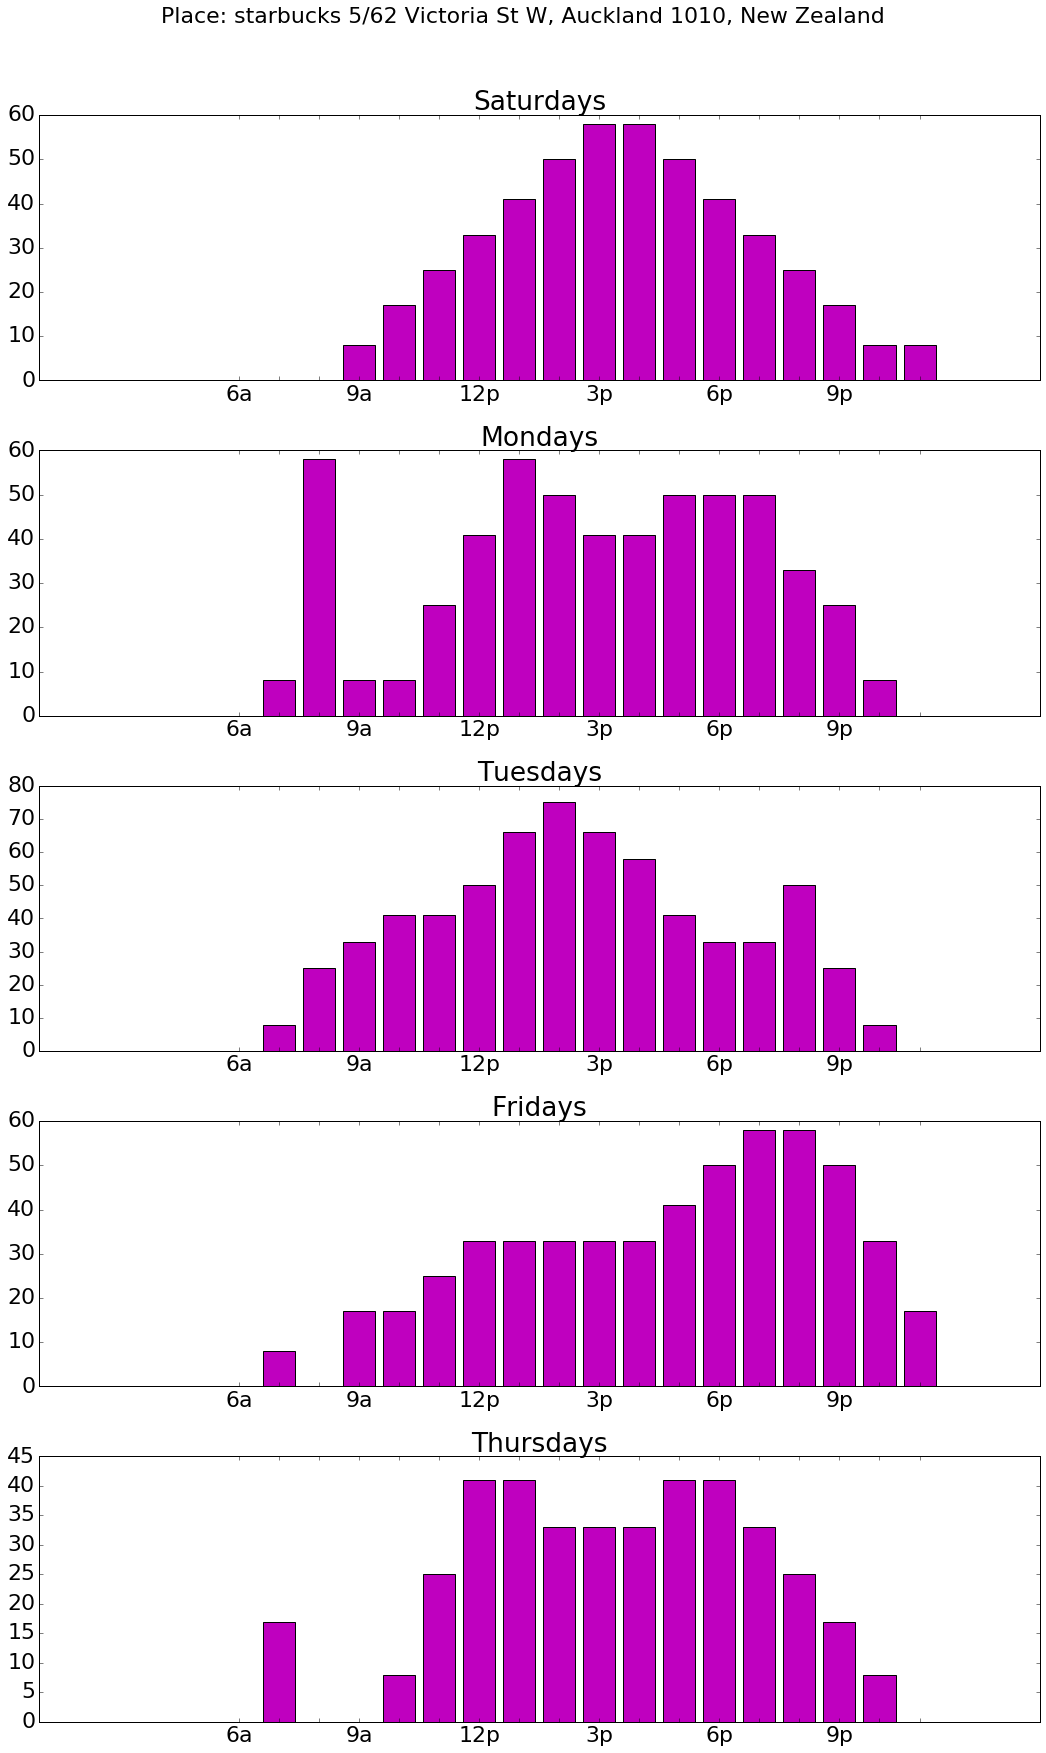

In [7]:
tt = popular_times[1]



tt_data = tt['data']
num_plots = len(tt_data)

fig, ax_arr = plt.subplots(num_plots, figsize=(15,25))


for ii, ee in enumerate(tt_data.items()):
    """ee is a tuple. 
    The first element is the day of week and
    the second element is the histogram
    """
    ax = ax_arr[ii]
    ax.set_title(ee[0])
    ticks, yy = list(zip(*ee[1]))
    ind = np.arange(len(yy))
    width = 0.8
    ax.bar(ind, yy, width, align='center', color='m', tick_label=ticks)


plt.tight_layout()
plt.suptitle("Place: {}".format(tt['place']))
plt.subplots_adjust(top=0.92)
plt.show()